In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
# from ref_trajectory import generate_trajectory as traj
%matplotlib inline

As a general practice, you can separate parameters in a different file

In [ ]:
dt=0.1
V_MAX=1.2
W_MAX=1.0
K_MAX=0.5
MIN_DIST=1.0
ACC_MAX=0.5
W_DOT_MAX=3.0
LATERAL_ACC_MAX=1.5
goal_threshold= 0.05
pred_horizon= 10 
w_cte= 1.0
w_speed=1.0
safety_margin = 0.5
v = 1.0
dt = 0.1
num_pts = 50
num_st_pts = int(v/dt)

There are 3 functions we need to write for DWA

1. Simulate unicyle - we will slightly modify it to simulate $N$ steps 

2. Command Window - Entire set of acceptable control space $\{(v_1, \omega_1),(v_2,\omega_2),\cdots (v_N,\omega_N\}$ given the current $v$ and $\omega$

3. track - get $(v, \omega )$ for path with the lowest cost

In the first iteration, let us not integrate collision checking. We will integrate these pieces, once DWA is verified to work for a few paths!

Below is a snippet to show how to generate Cartesian product of v and omega. Change the max/ min velocity values and visualize the set

In [ ]:
v_min, v_max = 0.0, 0.4
w_min, w_max = -0.1, 0.1
vs = np.linspace(v_min, v_max, num=5)
ws = np.linspace(w_min, w_max, num=3)
commands = np.transpose([np.tile(vs, len(ws)), np.repeat(ws, len(vs))])
print(len(commands))
print(commands)


15
[[ 0.  -0.1]
 [ 0.1 -0.1]
 [ 0.2 -0.1]
 [ 0.3 -0.1]
 [ 0.4 -0.1]
 [ 0.   0. ]
 [ 0.1  0. ]
 [ 0.2  0. ]
 [ 0.3  0. ]
 [ 0.4  0. ]
 [ 0.   0.1]
 [ 0.1  0.1]
 [ 0.2  0.1]
 [ 0.3  0.1]
 [ 0.4  0.1]]


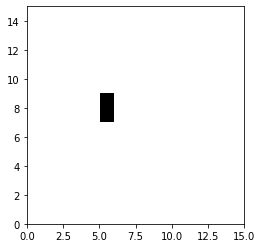

In [ ]:
#choose resolution and dimensions
grid_res = 1
grid_span =  15 # square circuit dimensions in m

#calculate grid_shape from grid
# dimensions have to be integers
grid_shape = (np.array([grid_span]*2)/grid_res).astype('int')
#Initialize 
grid_data = np.zeros(grid_shape)

#Create rectangular obstacles in world co-ordinates
#xmin, xmax, ymin, ymax
obstacles = np.array([[5,6,7,9]])#[5,6,7,9],[[25, 26, 10, 40],
                      # [2, 8, 16, 20]]) 
for obs in obstacles:
    # calculate obstacles extent in pixel coords
    xmin, xmax, ymin, ymax = (obs/grid_res).astype('int')
    # mark them as occupied
    grid_data[xmin:xmax ,ymin:ymax ] = 1.0

#calculate the extents    
x1, y1 = 0, 0
x2, y2 = grid_span, grid_span

#imshow() from prior cell
plt.figure()
plt.imshow(1-grid_data.T, origin='lower', cmap=plt.cm.gray, extent=[x1,x2,y1,y2] )
plt.show()

In [ ]:
def cubic_spiral(theta_i, theta_f, n=10):
    x = np.linspace(0, 1, n)
    #-2*x**3 + 3*x**2
    thetas = theta_i + (theta_f-theta_i)*(-2*x**3+3*x**2)
    return thetas
    
def straight(dist, curr_pose, n=num_st_pts):
    x0, y0, t0 = curr_pose
    # the straight-line may be along x or y axis
    #curr_theta will determine the orientation
    #write your code here
    xf, yf = x0 + dist*np.cos(t0), y0 + dist*np.sin(t0)
    #x, y are just linear interpolations between 
    #(x0,xf) and (y0,yf) respectively
    x = np.linspace(x0, xf, int(dist*n))
    y = np.linspace(y0, yf, int(dist*n))

    #t0 does not change for straight
    return x, y, t0*np.ones_like(x)

def turn(change, curr_pose, n=num_pts):
    # adjust scaling constant (n) for desired turn radius
    # Ex: n = 50, v = 1 is for 3m radius
    # n = 100 is for 6m radius
     x0, y0, t0 = curr_pose
     theta = cubic_spiral(t0, t0 + np.deg2rad(change), n)
     x= x0 + np.cumsum(v*np.cos(theta)*dt)
     y= y0 + np.cumsum(v*np.sin(theta)*dt)
     return x, y, theta

def generate_trajectory(route, init_pose = (0, 0,np.pi/2), radius=3.0):
    curr_pose = init_pose
    func = {'straight': straight, 'turn': turn}
    scale = {'straight': 10, 'turn': int(50*radius/3.0)}
    x, y, t = np.array([]), np.array([]),np.array([])
    for manoeuvre, command in route:
        print(f'manoeuvre {manoeuvre} scale {scale[manoeuvre]}')
        # call straight() or turn() depending on manoeuvre
        # single statement can be used in Python to achieve this
        #func is a dictionary containing the function names
        px, py, pt = func[manoeuvre](command, curr_pose, scale[manoeuvre])
        #px, py, pt = your code here
        #last pose of previous manoeuvre recorded
        curr_pose = px[-1],py[-1],pt[-1] 
        x = np.concatenate([x, px])
        y = np.concatenate([y, py])
        t = np.concatenate([t, pt])
        
    return np.vstack([x, y, t])

In [ ]:
def simulate_unicycle(pose, v,w, N=1, dt=0.1):
    x, y, t = pose
    poses = []
    for _ in range(N):
        #complete unicycle equations
        x += v*np.cos(t)*dt 
        y += v*np.sin(t)*dt
        t += w*dt
        #write your code to add to poses list
        poses.append((x,y,t))
    return np.array(poses)

def command_window(v, w, dt=0.1):
    """Returns acceptable v,w commands given current v,w"""
    # velocity can be (0, V_MAX)
    # ACC_MAX = max linear acceleration
    v_max = min(V_MAX, v + ACC_MAX*dt)
    v_min = max(0, v - ACC_MAX*dt)
    # omega can be (-W_MAX, W_MAX)
    #W_DOT_MAX = max angular acceleration
    
    w_max = min(W_MAX, w + W_DOT_MAX*dt)
    w_min = max(-W_MAX, w - W_DOT_MAX*dt)
    
    #generate quantized range for v and omega
    vs = np.linspace(v_min, v_max, num=11)
    ws = np.linspace(w_min, w_max, num=21)
    
    #cartesian product of [vs] and [ws]
    #remember there are 0 velocity entries which have to be discarded eventually
    commands = np.transpose([np.tile(vs, len(ws)), np.repeat(ws, len(vs))])
    
    #calculate kappa for the set of commands
    epsilon = 1e-6
    kappa = commands[:,1]/(commands[:,0]+epsilon)
    #epsilon used to avoid divide by zero error

    #index only combinations < max curvature and non-zero v
    #write code here
    # kappa > k_max and v > 0
    valid_commands = commands[(kappa < K_MAX) & (commands[:,0] > 0)]
    
    return valid_commands

def collision_check(grid, local_traj):
    xmax, ymax = grid.shape
    X, Y = np.meshgrid(np.arange(xmax), np.arange(ymax))
    occupied_pt = grid[X,Y] == 1
    n = local_traj.shape[0]
    xc, yc = (local_traj[:,0]/grid_res), (local_traj[:,1]/grid_res)
    r = safety_margin/ grid_res
    X_dash = np.repeat(X[:, :, np.newaxis], n, axis=2)
    Y_dash = np.repeat(Y[:, :, np.newaxis], n, axis=2)
    inside_circle = ((X_dash-xc)**2 +(Y_dash-yc)**2 - r**2 < 0).any(axis=2)
    if np.sum(np.multiply(inside_circle, occupied_pt)):
            return True
    return False

def track(ref_path, pose, v, w, grid, dt=0.1):
    commands = command_window(v, w, dt)
    #initialize path cost
    best_cost, best_command = np.inf, None
    for i, (v, w) in enumerate(commands):
        local_path = simulate_unicycle(pose,v,w,N=pred_horizon) #Number of steps = prediction horizon
        
        if collision_check(grid, local_path): #ignore colliding paths
            print("local path has a collision")
            continue
        
        #calculate cross-track error
        #can use a simplistic definition of 
        #how close is the last pose in local path from the ref path
        
        cte = np.linalg.norm(ref_path[-1,0:2]-local_path[-1,0:2])
        
        #other cost functions are possible
        #can modify collision checker to give distance to closest obstacle
        cost = w_cte*cte + w_speed*(V_MAX - v)**2 
        
        #check if there is a better candidate
        if cost < best_cost:
            best_cost, best_command = cost,[v,w]

    if best_command:
        return best_command
    else:
        return [0, 0]

In [ ]:
start_pose = np.array([0, 0, np.pi/2])
route = [("straight", 5),("turn", -90),("straight", 6),("turn", 90),("straight", 6)]
radius = 2
ref_path = generate_trajectory(route,start_pose,radius)
ref_path = ref_path.T

pose = start_pose
logs = []
path_index = 0
v, w = 1, 0

while path_index < len(ref_path)-1:
    t0 = time.time()
    local_ref_path = ref_path[path_index:path_index+pred_horizon]
    # update path_index using current pose and local_ref_path
    path_index += 1 
    # get next command
    v, w = track(local_ref_path,pose,v,w,grid_data)
    
    #simulate vehicle for 1 step
    # remember the function now returns a trajectory, not a single pose
    pose = simulate_unicycle(pose,v,w)[0]
    
    #update logs
    logs.append([*pose, v, w])
    t1 = time.time() #simplest way to time-profile your code
    print(f"idx:{path_index}, v:{v:0.3f}, w:{w:0.3f}, time:{(t1-t0) * 1000:0.1f}ms")


manoeuvre straight scale 10
manoeuvre turn scale 33
manoeuvre straight scale 10
manoeuvre turn scale 33
manoeuvre straight scale 10
idx:1, v:0.950, w:0.000, time:54.0ms
idx:2, v:0.930, w:0.000, time:44.5ms
idx:3, v:0.940, w:0.000, time:44.6ms
idx:4, v:0.950, w:0.000, time:44.3ms
idx:5, v:0.950, w:0.000, time:51.8ms
idx:6, v:0.960, w:0.000, time:46.5ms
idx:7, v:0.960, w:0.000, time:46.8ms
idx:8, v:0.970, w:0.000, time:46.8ms
idx:9, v:0.980, w:0.000, time:59.6ms
idx:10, v:0.980, w:0.000, time:52.7ms
idx:11, v:0.980, w:0.000, time:44.0ms
idx:12, v:0.990, w:0.000, time:43.7ms
idx:13, v:0.990, w:0.000, time:52.9ms
idx:14, v:0.990, w:0.000, time:47.4ms
idx:15, v:1.000, w:0.000, time:48.3ms
idx:16, v:1.000, w:0.000, time:47.2ms
idx:17, v:1.000, w:0.000, time:44.1ms
idx:18, v:1.000, w:0.000, time:44.6ms
idx:19, v:1.010, w:0.000, time:51.4ms
idx:20, v:1.010, w:0.000, time:50.4ms
idx:21, v:1.010, w:0.000, time:48.5ms
idx:22, v:1.010, w:0.000, time:44.8ms
idx:23, v:1.010, w:0.000, time:43.7ms
idx

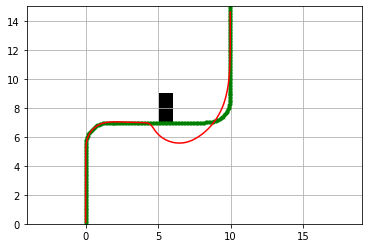

In [ ]:
poses = np.array(logs)[:,:3]
plt.figure()
plt.axes().set_aspect('equal', 'datalim')
plt.imshow(1-grid_data.T, origin='lower', cmap=plt.cm.gray, extent=[x1,x2,y1,y2] )
plt.plot(ref_path[:,0], ref_path[:,1], '.', c='g')
plt.plot(poses[:,0], poses[:,1], c='r')

#imshow() from prior cell

plt.grid()
plt.show()


Now it should be relatively straight-forward to integrate collision checking in the grid environment the robot is going to navigate